In [1]:
import pandas as pd

from pandas_datareader import data as pdr
import yfinance as yf
import streamlit as st
import numpy as np

from statsmodels.tsa.stattools import acf
from scipy.stats import wilcoxon, hmean

from tqdm.notebook import tqdm
from multiprocess import Pool
import multiprocessing

from matplotlib import pyplot as plt
import seaborn as sb

from optimal_weights import random_portfolio, min_var_portfolio, max_snr_portfolio
from evaluate_weights import evaluate_weights

import warnings
warnings.filterwarnings('ignore')

# Parameters

In [2]:
# SP100, as available on September 18, 2023
sp_100_symbols = [
    "AAPL",
    "ABBV",
    "ABT",
    "ACN",
    "ADBE",
    "AIG",
    "AMD",
    "AMGN",
    "AMT",
    "AMZN",
    "AVGO",
    "AXP",
    "BA",
    "BAC",
    "BK",
    "BKNG",
    "BLK",
    "BMY",
    "BRK.B",
    "C",
    "CAT",
    "CHTR",
    "CL",
    "CMCSA",
    "COF",
    "COP",
    "COST",
    "CRM",
    "CSCO",
    "CVS",
    "CVX",
    "DE",
    "DHR",
    "DIS",
    "DOW",
    "DUK",
    "EMR",
    "EXC",
    "F",
    "FDX",
    "GD",
    "GE",
    "GILD",
    "GM",
    "GOOG",
    "GOOGL",
    "GS",
    "HD",
    "HON",
    "IBM",
    "INTC",
    "JNJ",
    "JPM",
    "KHC",
    "KO",
    "LIN",
    "LLY",
    "LMT",
    "LOW",
    "MA",
    "MCD",
    "MDLZ",
    "MDT",
    "MET",
    "META",
    "MMM",
    "MO",
    "MRK",
    "MS",
    "MSFT",
    "NEE",
    "NFLX",
    "NKE",
    "NVDA",
    "ORCL",
    "PEP",
    "PFE",
    "PG",
    "PM",
    "PYPL",
    "QCOM",
    "RTX",
    "SBUX",
    "SCHW",
    "SO",
    "SPG",
    "T",
    "TGT",
    "TMO",
    "TMUS",
    "TSLA",
    "TXN",
    "UNH",
    "UNP",
    "UPS",
    "USB",
    "V",
    "VZ",
    "WFC",
    "WMT",
    "XOM"
]

In [3]:
symbols = sp_100_symbols #['AAPL', 'NKE', 'GOOGL', 'AMZN']
start = '2005-01-01' # expected datetime format is '%Y-%m-%d'
end = '2022-12-31'   # expected datetime format is '%Y-%m-%d

window_size = 100
num_portfolios = 10000

# Download historical prices (adjusted close)

In [8]:
yf.pdr_override()
price_df = pd.DataFrame()

for symbol in symbols:
    user_input = st.text_input('Enter Stock Ticker', symbol)
    tmp_df = pdr.get_data_yahoo(user_input, start=start, end=end)
    price_df = pd.concat([price_df, tmp_df['Adj Close']], axis='columns')

price_df.columns = symbols
price_df.head()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******


1 Failed download:
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

,AAPL,ABBV,ABT,ACN,ADBE,AIG,AMD,AMGN,AMT,AMZN,...,TXN,UNH,UNP,UPS,USB,V,VZ,WFC,WMT,XOM
2005-01-03 00:00:00,0.958030,NaN,14.365737,18.995510,30.838949,823.733826,21.410000,46.570461,14.322227,2.2260,...,15.982649,35.030224,11.536733,49.120880,17.305241,NaN,14.333459,18.186169,35.904148,26.668758
2005-01-04 00:00:00,0.967869,NaN,14.221071,18.548903,30.024111,826.478516,20.209999,45.831482,14.132943,2.1070,...,15.599282,34.670273,11.256179,48.496784,17.221642,NaN,14.188316,18.200851,35.816654,26.487743
2005-01-05 00:00:00,0.976345,NaN,14.057925,18.476866,29.859142,840.201233,19.750000,45.106976,14.006755,2.0885,...,15.129983,34.791592,11.153540,48.398537,17.310808,NaN,14.167070,18.221409,35.863773,26.349314
2005-01-06 00:00:00,0.977103,NaN,14.374969,18.311186,29.364239,841.573425,19.719999,45.527203,14.132943,2.0525,...,15.070482,35.559967,11.221968,48.346516,17.271795,NaN,14.136694,18.286041,36.375267,26.684744
2005-01-07 00:00:00,1.048247,NaN,14.621226,19.168390,29.384233,843.070251,19.920000,45.621372,14.385320,2.1160,...,15.149809,35.276882,11.085115,48.254059,16.970835,NaN,14.086652,18.262535,36.334888,26.509031


In [16]:
symbols_with_few_ticks = price_df.columns[price_df.isna().sum(axis="index") > 0]
symbols_with_few_ticks

Index(['ABBV', 'AVGO', 'BRK.B', 'CHTR', 'DOW', 'GM', 'KHC', 'MA', 'META', 'PM',
       'PYPL', 'TMUS', 'TSLA', 'V'],
      dtype='object')

In [17]:
price_df.drop(labels=symbols_with_few_ticks, axis="columns", inplace=True, errors="ignore")
price_df

,AAPL,ABT,ACN,ADBE,AIG,AMD,AMGN,AMT,AMZN,AXP,...,TMO,TXN,UNH,UNP,UPS,USB,VZ,WFC,WMT,XOM
2005-01-03 00:00:00,0.958030,14.365737,18.995510,30.838949,823.733826,21.410000,46.570461,14.322227,2.226000,36.735237,...,28.283670,15.982649,35.030224,11.536733,49.120880,17.305241,14.333459,18.186169,35.904148,26.668758
2005-01-04 00:00:00,0.967869,14.221071,18.548903,30.024111,826.478516,20.209999,45.831482,14.132943,2.107000,36.183327,...,27.931078,15.599282,34.670273,11.256179,48.496784,17.221642,14.188316,18.200851,35.816654,26.487743
2005-01-05 00:00:00,0.976345,14.057925,18.476866,29.859142,840.201233,19.750000,45.106976,14.006755,2.088500,35.847496,...,27.854839,15.129983,34.791592,11.153540,48.398537,17.310808,14.167070,18.221409,35.863773,26.349314
2005-01-06 00:00:00,0.977103,14.374969,18.311186,29.364239,841.573425,19.719999,45.527203,14.132943,2.052500,35.663120,...,27.873901,15.070482,35.559967,11.221968,48.346516,17.271795,14.136694,18.286041,36.375267,26.684744
2005-01-07 00:00:00,1.048247,14.621226,19.168390,29.384233,843.070251,19.920000,45.621372,14.385320,2.116000,35.399715,...,27.464132,15.149809,35.276882,11.085115,48.254059,16.970835,14.086652,18.262535,36.334888,26.509031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23 00:00:00,131.127045,106.058311,261.928528,338.450012,61.630920,64.519997,255.079041,205.554001,85.250000,144.877289,...,539.237000,159.378784,523.429626,204.745972,170.240173,40.916451,35.781876,39.736374,141.610046,105.091942
2022-12-27 00:00:00,129.307251,106.440666,261.160767,335.089996,61.796806,63.270000,254.566772,205.563751,83.040001,144.256454,...,543.984192,158.797043,524.099487,205.145889,170.163223,41.342659,36.564396,39.794556,141.649460,106.552094
2022-12-28 00:00:00,125.339417,105.715179,259.004974,328.329987,61.367458,62.570000,252.662766,204.784012,81.820000,141.911148,...,541.959656,156.285843,520.612122,201.780762,166.970200,41.058517,36.154503,39.872124,139.167313,104.801834
2022-12-29 00:00:00,128.889572,108.146538,264.182709,337.579987,62.089542,64.820000,254.344452,210.281296,84.180000,145.172913,...,555.523376,159.999313,522.020874,204.072937,169.028366,41.728939,36.573711,40.075760,140.014389,105.594772


In [21]:
price_df.pct_change().describe()

,AAPL,ABT,ACN,ADBE,AIG,AMD,AMGN,AMT,AMZN,AXP,...,TMO,TXN,UNH,UNP,UPS,USB,VZ,WFC,WMT,XOM
count,4530.000000,4530.000000,4530.000000,4530.000000,4530.000000,4530.000000,4530.000000,4530.000000,4530.000000,4530.000000,...,4530.000000,4530.000000,4530.000000,4530.000000,4530.000000,4530.000000,4530.000000,4530.000000,4530.000000,4530.000000
mean,0.001301,0.000541,0.000715,0.000761,0.000201,0.000915,0.000509,0.000740,0.001095,0.000563,...,0.000796,0.000678,0.000790,0.000795,0.000386,0.000426,0.000290,0.000509,0.000382,0.000451
std,0.020858,0.013890,0.016470,0.021571,0.038958,0.036785,0.016465,0.017435,0.024336,0.022858,...,0.016777,0.018393,0.019771,0.018012,0.015245,0.021539,0.012868,0.026138,0.012857,0.017029
min,-0.179195,-0.097857,-0.134543,-0.190346,-0.607908,-0.261798,-0.095846,-0.151638,-0.218220,-0.175949,...,-0.106369,-0.146213,-0.186362,-0.140089,-0.102500,-0.181653,-0.080685,-0.238223,-0.113758,-0.139525
25%,-0.008611,-0.006227,-0.007133,-0.008942,-0.009164,-0.017291,-0.007702,-0.007802,-0.009981,-0.007751,...,-0.007279,-0.008759,-0.007938,-0.008084,-0.006329,-0.007344,-0.006189,-0.008481,-0.005692,-0.007563
50%,0.001001,0.000456,0.000933,0.001007,0.000282,0.000000,0.000130,0.000785,0.000560,0.000453,...,0.000755,0.000846,0.000723,0.000676,0.000181,0.000407,0.000325,0.000000,0.000433,0.000298
75%,0.011992,0.007757,0.008588,0.011062,0.009710,0.018736,0.008682,0.009100,0.012229,0.009439,...,0.009188,0.010632,0.009329,0.009821,0.007291,0.007860,0.006795,0.008699,0.006387,0.008535
max,0.139049,0.109360,0.163668,0.177193,0.660001,0.522901,0.151021,0.202199,0.269497,0.218823,...,0.168983,0.135294,0.347551,0.130042,0.143758,0.228412,0.146323,0.327645,0.117085,0.171905


In [22]:
price_df.to_csv("../data/price_df.csv")

# Take independent subsamples (windows) from the data and generate portfolios

In [4]:
def get_largest_significant_lags(df, alfa=0.05):
    largest_significant_lag = 0

    for i in range(df.shape[1]):
        significant_lags = np.where(acf(df.iloc[:, i], missing="conservative", qstat=True)[-1] < alfa)[0]

        if significant_lags.shape[0] == 0:
            largest_significant_lag = max(largest_significant_lag, 0)
        else:
            # zero lag is ignored in the LB-test, so the index must be shifted by 1
            largest_significant_lag = max(largest_significant_lag, significant_lags[-1] + 1)

    return largest_significant_lag

In [5]:
price_df = pd.read_csv("../data/price_df.csv", index_col=0)
max_pool = multiprocessing.cpu_count()

window_start = 0
window_end = window_size
largest_significant_lag = 0
num_assets = len(price_df.columns)

results = []

with tqdm(total=price_df.shape[0]) as pbar:

    while window_start + window_size < price_df.shape[0]:
        window_df = price_df.iloc[window_start:window_end, :]

        # find mean and covariance of returns
        cov_matrix = window_df.pct_change().cov()
        exp_returns = window_df.pct_change().mean()

        cumul_returns_df = window_df / window_df.iloc[0,:]

        for longonly in [True, False]:

            w_min_var = min_var_portfolio(cov_matrix, longonly=longonly)
            w_max_snr = max_snr_portfolio(cov_matrix, exp_returns, longonly=longonly)

            # find random portfolio Hurst exponent(s)
            with Pool(max_pool) as p:
                pool_outputs = list(
                    tqdm(
                        p.imap(
                            random_portfolio,
                            [(seed, num_assets, cumul_returns_df, longonly) for seed in range(num_portfolios)]
                        ),
                        total=num_portfolios
                    )
                )

            results.append(
                evaluate_weights(w_min_var, cumul_returns_df) +
                evaluate_weights(w_max_snr, cumul_returns_df) +
                [ sum(x)/float(len(pool_outputs)) for x in zip(*pool_outputs) ] +
                [longonly]
            )

        ### move window
        largest_significant_lag = get_largest_significant_lags(window_df.pct_change(), alfa=0.05)

        pbar.update(window_size + largest_significant_lag)

        window_start = window_end + largest_significant_lag
        window_end = window_start + window_size

    pbar.update(price_df.shape[0] - window_end)

  0%|          | 0/4531 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [6]:
results_df = pd.DataFrame(results, columns=["H1_minvar", "H2_minvar", "H3_minvar", "H4_minvar", "H1_maxsnr", "H2_maxsnr", "H3_maxsnr", "H4_maxsnr", "H1_random", "H2_random", "H3_random", "H4_random", "longonly"])
results_df.to_csv("../data/results_df.csv")
results_df

,H1_minvar,H2_minvar,H3_minvar,H4_minvar,H1_maxsnr,H2_maxsnr,H3_maxsnr,H4_maxsnr,H1_random,H2_random,H3_random,H4_random,longonly
0,0.541920,0.260413,0.331039,0.200285,0.635925,0.492436,0.383633,0.615994,0.634676,0.330548,0.388266,0.549900,True
1,0.666426,0.463672,0.540746,0.725452,0.793514,0.854148,0.629246,0.935715,0.629946,0.414944,0.427641,0.463750,False
2,0.642253,0.278925,0.365270,0.452409,0.747686,0.569009,0.432066,0.819657,0.730810,0.374599,0.458902,0.580783,True
3,0.520615,0.591708,0.366230,0.888412,0.536583,0.835906,0.263643,0.876745,0.629550,0.410674,0.408426,0.485104,False
4,0.617988,0.228837,0.371385,0.237795,0.554288,0.707622,0.231540,0.863910,0.386426,0.284029,0.139090,0.379823,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,0.750355,0.818057,0.573608,0.902261,0.548139,0.870138,0.162516,0.933678,0.604774,0.432806,0.406762,0.450632,False
70,0.763642,0.453557,0.505066,0.516682,0.648937,0.733661,0.215047,0.658647,0.709105,0.478776,0.398973,0.395470,True
71,0.425768,0.728510,0.227381,0.470666,0.578343,0.892274,0.402496,0.937543,0.663245,0.466915,0.442404,0.485610,False
72,0.739514,0.460941,0.514864,0.415649,0.626001,0.533760,0.432493,0.700425,0.568125,0.457313,0.383555,0.391500,True


# Analyze portfolios

In [7]:
results_df = pd.read_csv("../data/results_df.csv", index_col=0)
results_df

,H1_minvar,H2_minvar,H3_minvar,H4_minvar,H1_maxsnr,H2_maxsnr,H3_maxsnr,H4_maxsnr,H1_random,H2_random,H3_random,H4_random,longonly
0,0.541920,0.260413,0.331039,0.200285,0.635925,0.492436,0.383633,0.615994,0.634676,0.330548,0.388266,0.549900,True
1,0.666426,0.463672,0.540746,0.725452,0.793514,0.854148,0.629246,0.935715,0.629946,0.414944,0.427641,0.463750,False
2,0.642253,0.278925,0.365270,0.452409,0.747686,0.569009,0.432066,0.819657,0.730810,0.374599,0.458902,0.580783,True
3,0.520615,0.591708,0.366230,0.888412,0.536583,0.835906,0.263643,0.876745,0.629550,0.410674,0.408426,0.485104,False
4,0.617988,0.228837,0.371385,0.237795,0.554288,0.707622,0.231540,0.863910,0.386426,0.284029,0.139090,0.379823,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,0.750355,0.818057,0.573608,0.902261,0.548139,0.870138,0.162516,0.933678,0.604774,0.432806,0.406762,0.450632,False
70,0.763642,0.453557,0.505066,0.516682,0.648937,0.733661,0.215047,0.658647,0.709105,0.478776,0.398973,0.395470,True
71,0.425768,0.728510,0.227381,0.470666,0.578343,0.892274,0.402496,0.937543,0.663245,0.466915,0.442404,0.485610,False
72,0.739514,0.460941,0.514864,0.415649,0.626001,0.533760,0.432493,0.700425,0.568125,0.457313,0.383555,0.391500,True


In [8]:
portfolios = ["maxsnr", "minvar", "random"]

# H1: rescaled range
# H2: robust variance of lagged difference
# H3: variance of lagged difference
# H4: fractal dimensiong
hurst_estimators = ["H1", "H2", "H3", "H4"]

## Check Hurst estimator distributions

In [31]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 18

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE+10)  # fontsize of the figure title

Long-only case

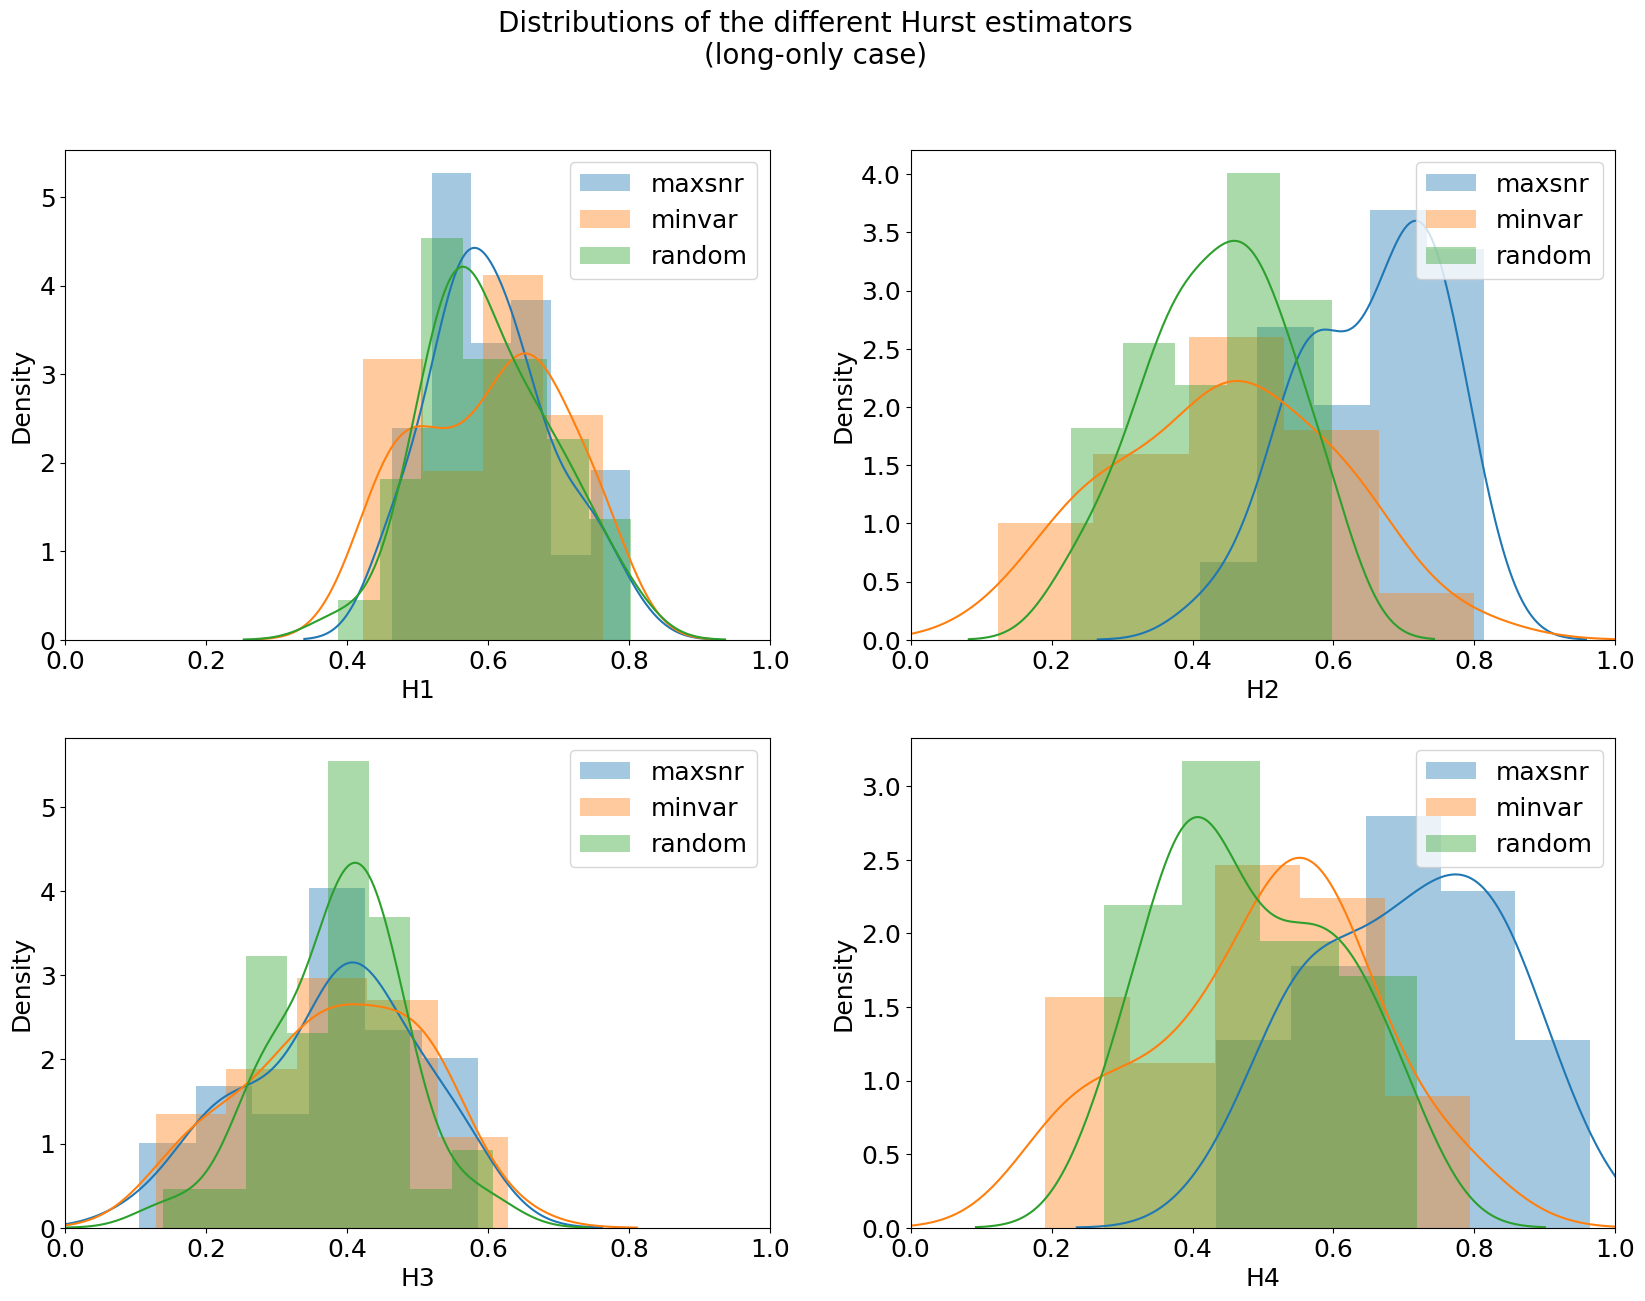

In [32]:
longonly = results_df.longonly == True

fig, axes = plt.subplots(2, 2, figsize=(20, 14))
fig.suptitle("Distributions of the different Hurst estimators\n(long-only case)", fontsize=20)

for j in range(len(hurst_estimators)):
    for i in range(len(portfolios)):
        ax = axes[j // 2][j % 2]
        sb.distplot(results_df[longonly][hurst_estimators[j]+"_"+portfolios[i]], kde=True, label=portfolios[i], ax=ax)
        ax.set_xlabel(hurst_estimators[j])
        ax.legend(loc="upper right")
        ax.set_xlim(0.0, 1.0)

<Axes: ylabel='Density'>

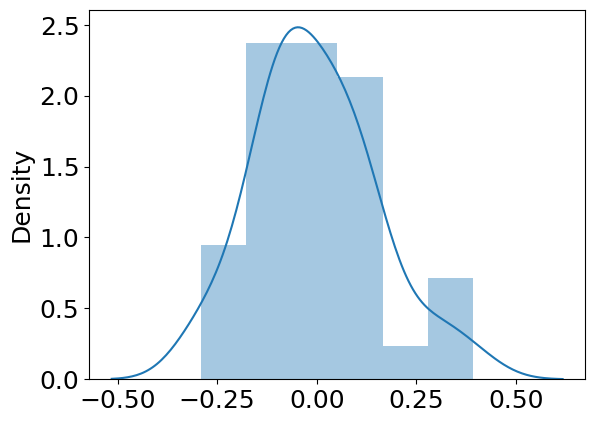

In [38]:
sb.distplot(results_df[longonly][hurst_estimators[2]+"_"+portfolios[0]] - results_df[longonly][hurst_estimators[2]+"_"+portfolios[1]], kde=True, label=portfolios[i])

Long-short case

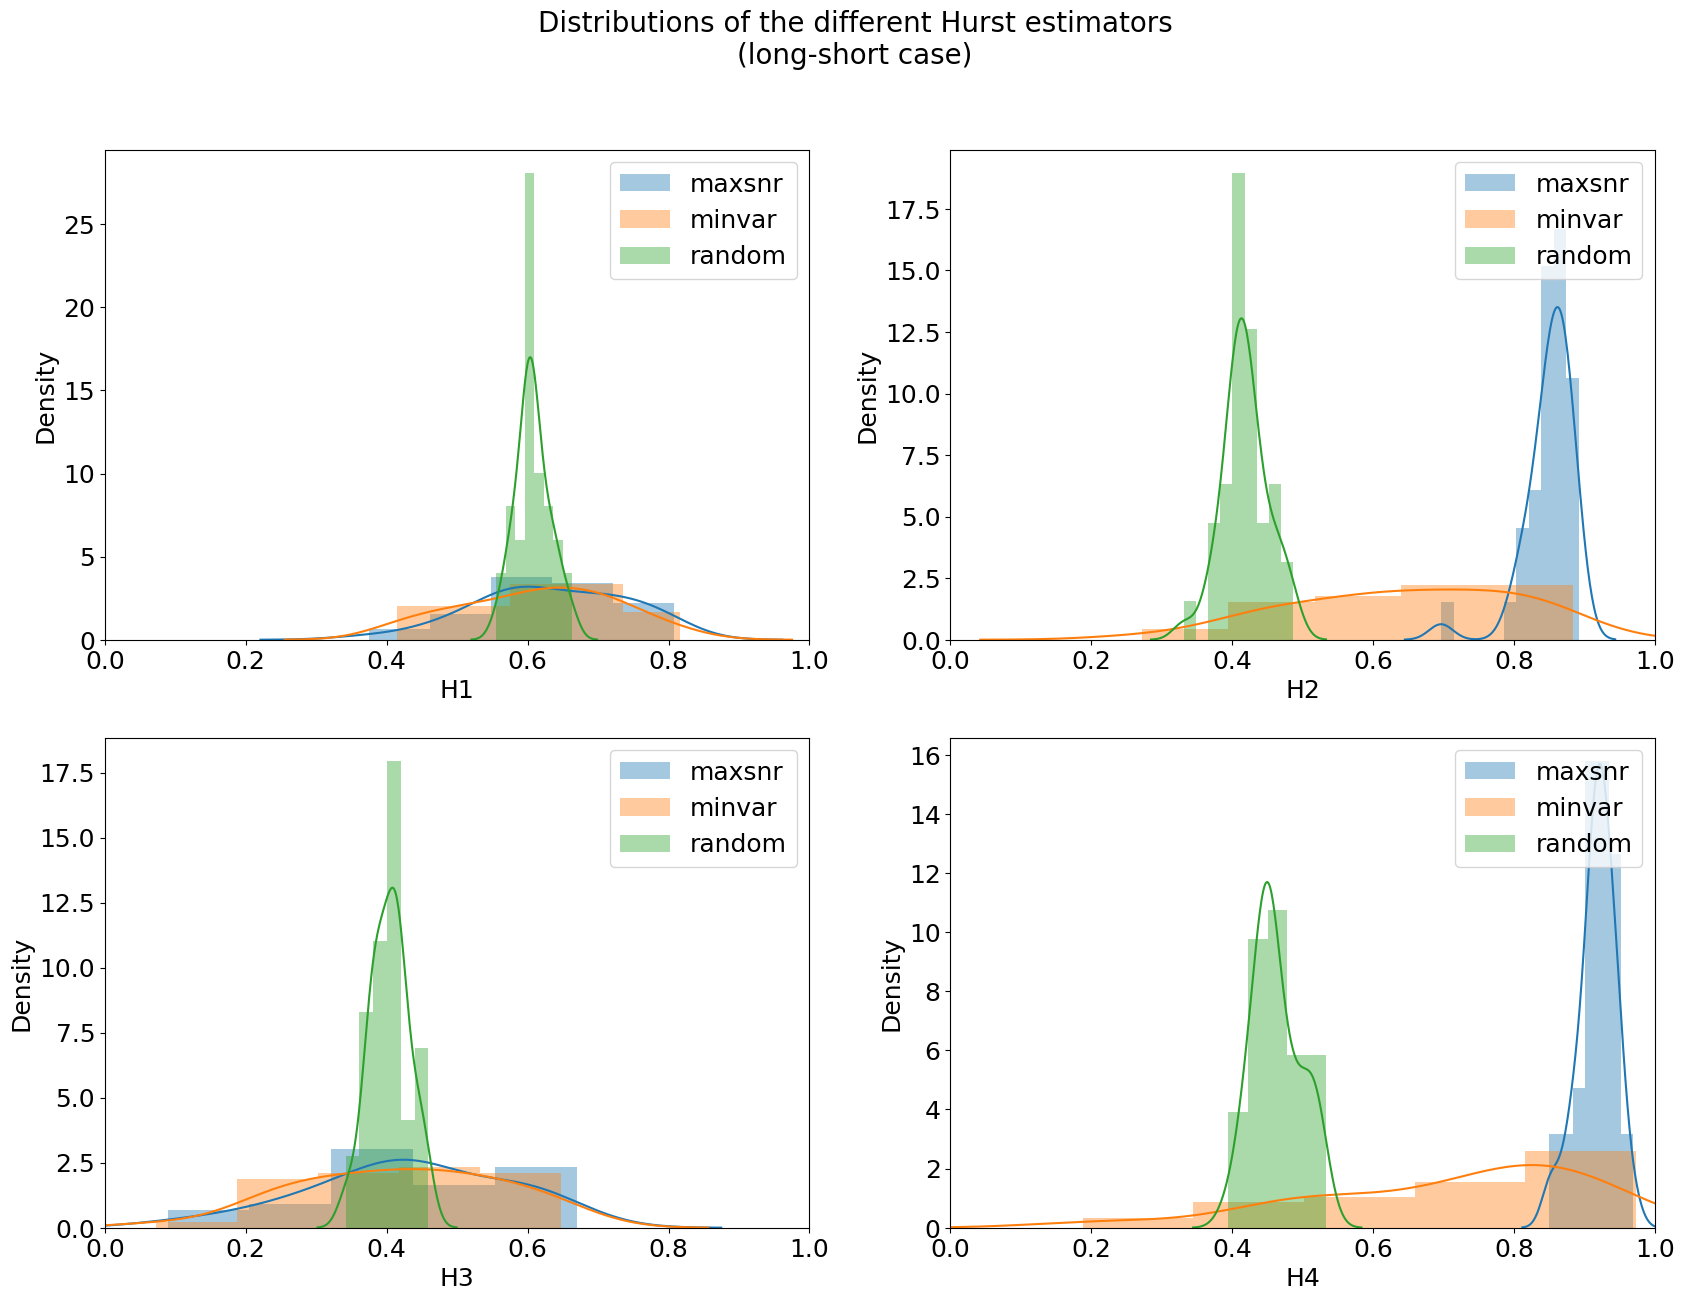

In [33]:
mask = results_df.longonly == False

fig, axes = plt.subplots(2, 2, figsize=(20, 14))
fig.suptitle("Distributions of the different Hurst estimators\n(long-short case)", fontsize=20)

for j in range(len(hurst_estimators)):
    for i in range(len(portfolios)):
        ax = axes[j // 2][j % 2]
        sb.distplot(results_df[~longonly][hurst_estimators[j]+"_"+portfolios[i]], kde=True, label=portfolios[i], ax=ax)
        ax.set_xlabel(hurst_estimators[j])
        ax.legend(loc="upper right")
        ax.set_xlim(0.0, 1.0)

## Hypothesis test: equivalence of means

In [11]:
# H0: sample means are equal
# H1: the first mean is larger than the second

Long-only case

In [12]:
index = []
data = []

# Test equivalence
cntr = 0
for i in range(len(portfolios)):
    for j in range(i+1, len(portfolios)):
        index.append((cntr, portfolios[i], "mean"))
        data.append([results_df[longonly][hurst_estimator+"_"+portfolios[i]].mean() for hurst_estimator in hurst_estimators] + [""])

        index.append((cntr, portfolios[j], "mean"))
        data.append([results_df[longonly][hurst_estimator+"_"+portfolios[j]].mean() for hurst_estimator in hurst_estimators] + [""])

        index.append((cntr, "Wilcoxon", "T"))
        index.append((cntr, "Wilcoxon", "p"))

        data.append([wilcoxon(results_df[longonly][hurst_estimator+"_"+portfolios[i]], results_df[longonly][hurst_estimator+"_"+portfolios[j]], alternative="greater")[0] for hurst_estimator in hurst_estimators] + [""])
        data.append([wilcoxon(results_df[longonly][hurst_estimator+"_"+portfolios[i]], results_df[longonly][hurst_estimator+"_"+portfolios[j]], alternative="greater")[1] for hurst_estimator in hurst_estimators])
        data[-1].append(hmean(data[-1]))

        cntr += 1

pd.DataFrame(data, index=pd.MultiIndex.from_tuples(index), columns=hurst_estimators+["hmp"])

H1            H2          H3            H4       hmp
0 maxsnr   mean    0.604439  6.527797e-01    0.379823  7.065956e-01          
  minvar   mean    0.603456  4.463133e-01    0.383310  4.989459e-01          
  Wilcoxon T     336.000000  6.900000e+02  326.000000  6.690000e+02          
           p       0.594262  6.402843e-10    0.650897  2.710294e-08       0.0
1 maxsnr   mean    0.604439  6.527797e-01    0.379823  7.065956e-01          
  random   mean    0.601786  4.340253e-01    0.387228  4.820728e-01          
  Wilcoxon T     320.000000  7.030000e+02  322.000000  6.970000e+02          
           p       0.683451  7.275958e-12    0.672738  1.018634e-10       0.0
2 minvar   mean    0.603456  4.463133e-01    0.383310  4.989459e-01          
  random   mean    0.601786  4.340253e-01    0.387228  4.820728e-01          
  Wilcoxon T     335.000000  3.910000e+02  340.000000  4.200000e+02          
           p       0.600035  2.802654e-01    0.570982  1.544099e-01  0.297127

Long-short case

In [13]:
index = []
data = []

# Test equivalence
cntr = 0
for i in range(len(portfolios)):
    for j in range(i+1, len(portfolios)):
        index.append((cntr, portfolios[i], "mean"))
        data.append([results_df[~longonly][hurst_estimator+"_"+portfolios[i]].mean() for hurst_estimator in hurst_estimators] + [""])

        index.append((cntr, portfolios[j], "mean"))
        data.append([results_df[~longonly][hurst_estimator+"_"+portfolios[j]].mean() for hurst_estimator in hurst_estimators] + [""])

        index.append((cntr, "Wilcoxon", "T"))
        index.append((cntr, "Wilcoxon", "p"))

        data.append([wilcoxon(results_df[~longonly][hurst_estimator+"_"+portfolios[i]], results_df[~longonly][hurst_estimator+"_"+portfolios[j]], alternative="greater")[0] for hurst_estimator in hurst_estimators] + [""])
        data.append([wilcoxon(results_df[~longonly][hurst_estimator+"_"+portfolios[i]], results_df[~longonly][hurst_estimator+"_"+portfolios[j]], alternative="greater")[1] for hurst_estimator in hurst_estimators])
        data[-1].append(hmean(data[-1]))

        cntr += 1

pd.DataFrame(data, index=pd.MultiIndex.from_tuples(index), columns=hurst_estimators+["hmp"])

H1            H2          H3            H4  hmp
0 maxsnr   mean    0.633623  8.502338e-01    0.431116  9.175407e-01     
  minvar   mean    0.613591  6.436100e-01    0.418040  7.074961e-01     
  Wilcoxon T     422.000000  7.030000e+02  387.000000  6.860000e+02     
           p       0.147343  7.275958e-12    0.300759  1.506123e-09  0.0
1 maxsnr   mean    0.633623  8.502338e-01    0.431116  9.175407e-01     
  random   mean    0.607238  4.183683e-01    0.403855  4.631614e-01     
  Wilcoxon T     460.000000  7.030000e+02  448.000000  7.030000e+02     
           p       0.051875  7.275958e-12    0.074532  7.275958e-12  0.0
2 minvar   mean    0.613591  6.436100e-01    0.418040  7.074961e-01     
  random   mean    0.607238  4.183683e-01    0.403855  4.631614e-01     
  Wilcoxon T     382.000000  6.880000e+02  398.000000  6.600000e+02     
           p       0.327262  9.968062e-10    0.246076  9.433279e-08  0.0

Long-short vs. long-only

In [15]:
index = []
data = []

# Test equivalence
for i in range(len(portfolios)):
    index.append((portfolios[i], "long-short", "mean"))
    data.append([results_df[~longonly][hurst_estimator+"_"+portfolios[i]].mean() for hurst_estimator in hurst_estimators] + [""])

    index.append((portfolios[i], "long-only", "mean"))
    data.append([results_df[longonly][hurst_estimator+"_"+portfolios[i]].mean() for hurst_estimator in hurst_estimators] + [""])

    index.append((portfolios[i], "Wilcoxon", "T"))
    index.append((portfolios[i], "Wilcoxon", "p"))

    data.append([wilcoxon(results_df[~longonly][hurst_estimator+"_"+portfolios[i]], results_df[longonly][hurst_estimator+"_"+portfolios[i]], alternative="greater")[0] for hurst_estimator in hurst_estimators] + [""])
    data.append([wilcoxon(results_df[~longonly][hurst_estimator+"_"+portfolios[i]], results_df[longonly][hurst_estimator+"_"+portfolios[i]], alternative="greater")[1] for hurst_estimator in hurst_estimators])
    data[-1].append(hmean(data[-1]))

pd.DataFrame(data, index=pd.MultiIndex.from_tuples(index), columns=hurst_estimators+["hmp"])

H1            H2          H3            H4  \
maxsnr long-short mean    0.633623  8.502338e-01    0.431116  9.175407e-01   
       long-only  mean    0.604439  6.527797e-01    0.379823  7.065956e-01   
       Wilcoxon   T     433.000000  7.030000e+02  479.000000  7.000000e+02   
                  p       0.112296  7.275958e-12    0.027341  3.637979e-11   
minvar long-short mean    0.613591  6.436100e-01    0.418040  7.074961e-01   
       long-only  mean    0.603456  4.463133e-01    0.383310  4.989459e-01   
       Wilcoxon   T     359.000000  6.550000e+02  421.000000  6.370000e+02   
                  p       0.458452  1.782537e-07    0.150850  1.368215e-06   
random long-short mean    0.607238  4.183683e-01    0.403855  4.631614e-01   
       long-only  mean    0.601786  4.340253e-01    0.387228  4.820728e-01   
       Wilcoxon   T     385.000000  2.740000e+02  416.000000  2.920000e+02   
                  p       0.311248  8.787820e-01    0.169188  8.151777e-01   

                             hmp  
maxsnr long-short mean            
       long-only  mean            
       Wilcoxon   T               
                  p          0.0  
minvar long-short mean            
       long-only  mean            
       Wilcoxon   T               
                  p     0.000001  
random long-short mean            
       long-only  mean            
       Wilcoxon   T               
                  p     0.348186